In [17]:
import numpy as np
import scipy.ndimage
import os
import glob
import matplotlib.pyplot as plt
import cv2
from PIL import Image, ImageSequence
import tifffile as tif

def add_noise(image, noise_type):
    if noise_type == "gaussian":
        row, col = image.shape
        mean = 0
        
        pixels = []
        pixels.extend(image.flatten())

        # Convert the list to a NumPy array
        pixels = np.array(pixels)

        # Compute the standard deviation
        std_dev = np.std(pixels)
        
        var = 0.1*std_dev
        sigma = var**0.5
        gauss = np.random.normal(mean, sigma, (row, col))
        gauss = gauss.reshape(row, col)
        noisy = image + gauss
        return np.clip(noisy, 0, 255)

    elif noise_type == "salt_and_pepper":
        s_vs_p = 0.5
        amount = 0.01
        out = np.copy(image)
        # Salt mode
        num_salt = int(np.ceil(amount * np.prod(image.size) * s_vs_p))
        coordsx = np.random.randint(0, image.shape[0] - 1, num_salt)
        coordsy = np.random.randint(0, image.shape[0] - 1, num_salt)
        for i in range(num_salt):
            out[coordsx[i], coordsy[i]] = 255
        # Pepper mode
        num_pepper = int(np.ceil(amount* image.size * (1. - s_vs_p)))
        coordsx = np.random.randint(0, image.shape[0] - 1, num_pepper)
        coordsy = np.random.randint(0, image.shape[0] - 1, num_pepper)
        for i in range(num_pepper):
            out[coordsx[i], coordsy[i]] = 0
        return np.clip(out, 0, 255)
    
    elif noise_type == "flare":

        # Identify light sources (simple thresholding for this example)
        light_sources = image > 200
        print(np.shape(light_sources))

        # Generate flare artifacts
        flare = np.zeros_like(image, dtype=np.float64)
        for i in range(light_sources.shape[0]):
            for j in range(light_sources.shape[1]):
                if light_sources[i, j]:
                    cv2.circle(flare, (j, i), 10, 255, -1, cv2.LINE_AA)
                    
        plt.imshow(flare)
        
        flare = flare.astype(np.uint8)

        # Make the flare semi-transparent by scaling it down
        flare = cv2.addWeighted(image, 0.7, flare, 0.3, 0)

        # Save the result
        return np.clip(flare, 0, 255)

    elif noise_type == "poisson":
        # Ensure all values are non-negative
        image = np.where(image < 0, 0, image)
        # Replace any NaN values with the median of the other pixel values
        image = np.where(np.isnan(image), np.nanmedian(image), image)
        vals = len(np.unique(image))
        vals = 2 ** np.ceil(np.log2(vals))
        noisy = np.random.poisson(image * vals) / float(vals)
        return np.clip(noisy, 0, 255)

    elif noise_type =="speckle":
        row, col = image.shape
        gauss = np.random.randn(row, col)
        gauss = gauss.reshape(row, col)        
        noisy = image + image * gauss*0.1
        return np.clip(noisy, 0, 255)

    elif noise_type == "blur":
        noisy = scipy.ndimage.gaussian_filter(image, sigma=.3)
        return np.clip(noisy, 0, 255)

    elif noise_type == "jpeg":
        encode_param = [int(cv2.IMWRITE_JPEG_QUALITY), 90] # You can change the last value to adjust the quality of jpeg encoding
        result, encimg = cv2.imencode('.jpg', image, encode_param)
        decimg = cv2.imdecode(encimg, cv2.IMREAD_GRAYSCALE)
        return np.clip(decimg, 0, 255)

    else:
        return image

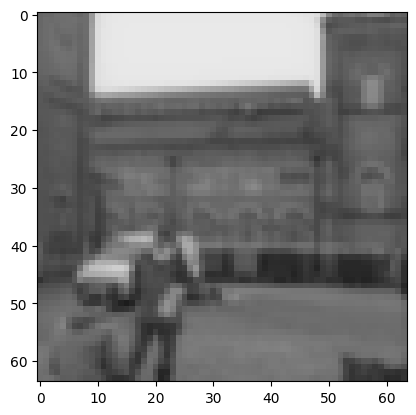

In [10]:
LR_names = glob.glob('lightfield_mini/train/LF/*')

LR = []
for j in range(len(LR_names)):
    image = []
    with Image.open(LR_names[j]) as im:
        for i, page in enumerate(ImageSequence.Iterator(im)):
            image.append(np.array(page))
            
    LR.append(image)

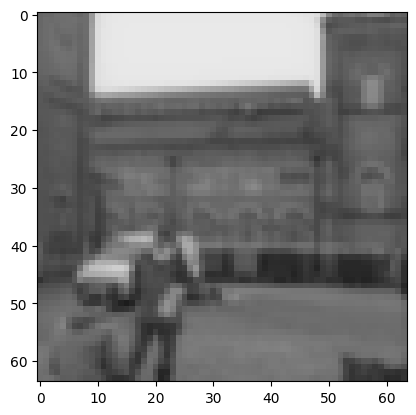

In [15]:
plt.imshow(LR[0][0], cmap='gray', vmin=0, vmax=255)

(64, 64)


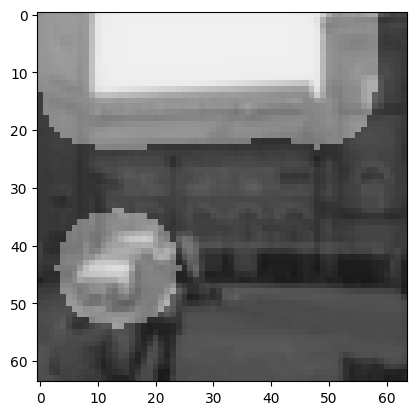

In [21]:
image = np.copy(LR[0][0])

# Add noise
noises = ["gaussian", "salt_and_pepper", "poisson", "speckle", "blur", "jpeg", "flare"]

noise_flags = [False]*7  # Apply all noises
noise_flags[6] = True

# for i, images in enumerate(LR):
#     for j, img in enumerate(images):
#         for k, noise in enumerate(noises):
#             if noise_flags[k]:
#                 LR[i][j] = add_noise(LR[i][j], noise)

for k, noise in enumerate(noises):
    if noise_flags[k]:
        image = add_noise(image, noise)
plt.imshow(image, cmap='gray', vmin=0, vmax=255)
    
# Save the image back to tiff format
# tif.imwrite("lightfield_noisy/train/LF/" + os.path.basename(LR_names[i]), np.stack(LR[i]), bigtiff=True)
